#### Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.

In [4]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [5]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [7]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [8]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [9]:
def residual(y, z):
    return - (z - y)

In [10]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [11]:
def get_error_plot(depth_tree_set):
    plt.figure(figsize=(15, 10))
    plt.xlabel('Trees number')
    plt.ylabel('MSE')
    for i in range(len(depth_tree_set)):
        depth = depth_tree_set[i][0]
        n_trees = len(depth_tree_set[i][1])
        train_err = depth_tree_set[i][2]
        test_err = depth_tree_set[i][3]
    
        plt.xlim(0, n_trees)
        plt.plot(list(range(n_trees)), train_err, label=f'train error, depth {depth}')
        plt.plot(list(range(n_trees)), test_err, label=f'test error, depth {depth}')
        
    plt.legend(loc='upper right')
    plt.show()

In [14]:
def n_trees_depth(n_trees_max, max_depth, eta = 0.1):
    depth_tree_set = []
    for d in max_depth:
        trees, train_errors, test_errors = gb_fit(n_trees_max, d, X_train, X_test, y_train, y_test, eta)
        depth_tree_set.append([d, trees, train_errors, test_errors])
    get_error_plot(depth_tree_set)
    return depth_tree_set

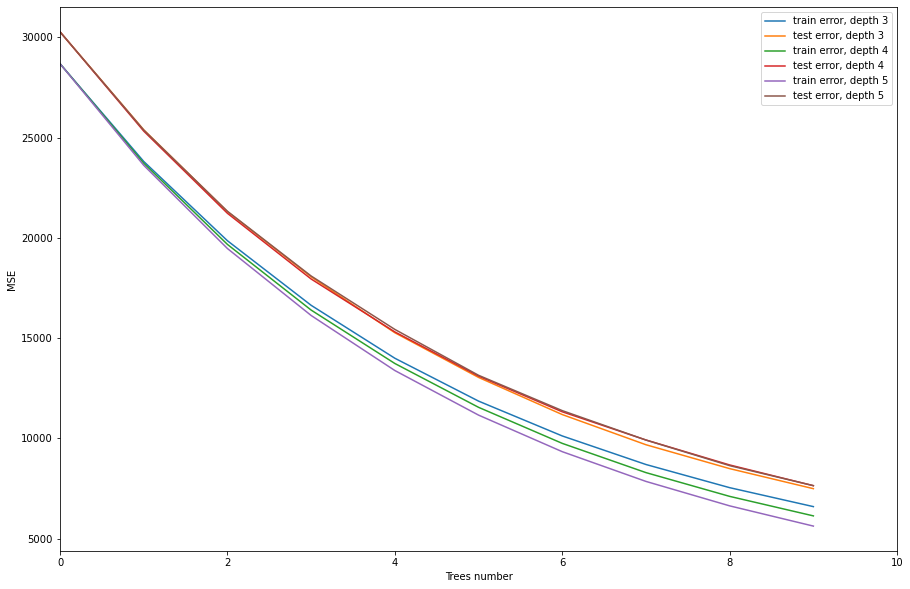

In [25]:
n_trees_max = 10
max_depth =  np.arange(start=3, stop=6, step=1)
sets = n_trees_depth(n_trees_max, max_depth)

#### Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [26]:
def get_bootstrap(data, labels, N, size):
    n_samples = int(size * data.shape[0])
    bootstrap = []

    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        bootstrap.append((b_data, b_labels))
  

    return bootstrap

In [31]:
def gb_fit_sgb(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    bootstrap = get_bootstrap(X_train, y_train, n_trees, 0.5)
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        b_X_train, b_y_train = bootstrap[i]   
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(b_X_train, b_y_train)
            
            train_errors.append(mean_squared_error(b_y_train, gb_predict(b_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(b_X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(b_y_train, target))
            
            train_errors.append(mean_squared_error(b_y_train, gb_predict(b_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [32]:
def n_trees_depth_sgb(n_trees_max, max_depth, eta = 0.1):    
    depth_tree_set = []
    for d in max_depth:
        trees, train_errors, test_errors = gb_fit_sgb(n_trees_max, d, X_train, X_test, y_train, y_test, eta)
        depth_tree_set.append([d, trees, train_errors, test_errors])
    get_error_plot(depth_tree_set)
    return depth_tree_set

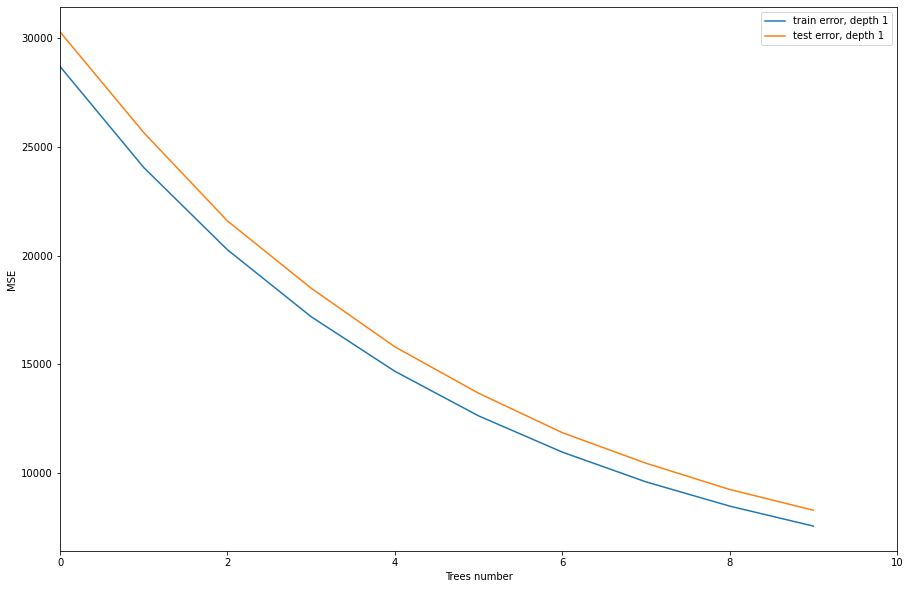

In [33]:
n_trees_max = 10
max_depth =  np.arange(start=1, stop=2, step=1)
sets = n_trees_depth(n_trees_max, max_depth)